# Change Point Analysis of Brent Oil Prices

This notebook implements simple change point detection to identify structural breaks in Brent oil prices.

In [1]:
import sys
import os
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from data_workflow import DataAnalysisWorkflow
from event_compiler import EventCompiler

print("✓ Libraries imported")

✓ Libraries imported


In [2]:
# Load data
oil_data = pd.read_csv("../data/raw/brent_oil_prices.csv")
oil_data['Date'] = pd.to_datetime(oil_data['Date'])
oil_data = oil_data.sort_values('Date').reset_index(drop=True)

log_returns = np.diff(np.log(oil_data['Price'].values))
print(f"Data loaded: {len(oil_data)} observations")
print(f"Log returns: {len(log_returns)} observations")

C:\Users\W-HP\AppData\Local\Temp\ipykernel_16228\3028324096.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  oil_data['Date'] = pd.to_datetime(oil_data['Date'])


Data loaded: 9011 observations
Log returns: 9010 observations


In [3]:
# Change point detection
def detect_change_point(data, window=100):
    n = len(data)
    variances = []
    
    for i in range(window, n-window):
        before = np.var(data[:i])
        after = np.var(data[i:])
        variances.append(abs(before - after))
    
    change_idx = np.argmax(variances) + window
    return change_idx

tau_mode = detect_change_point(log_returns)
change_date = oil_data.iloc[tau_mode+1]['Date']

print(f"Change point at index: {tau_mode}")
print(f"Change point date: {change_date.strftime('%Y-%m-%d')}")

Change point at index: 8328
Change point date: 2020-03-06


In [4]:
# Impact analysis
before_prices = oil_data.iloc[:tau_mode+1]['Price']
after_prices = oil_data.iloc[tau_mode+1:]['Price']

before_mean = before_prices.mean()
after_mean = after_prices.mean()
change_percent = ((after_mean - before_mean) / before_mean) * 100

print(f"Before change: ${before_mean:.2f}")
print(f"After change: ${after_mean:.2f}")
print(f"Percentage change: {change_percent:.1f}%")

Before change: $46.54
After change: $71.38
Percentage change: 53.4%


In [5]:
# Event association
event_compiler = EventCompiler()
events_df = event_compiler.compile_major_events()

time_diff = abs((events_df['date'] - pd.to_datetime(change_date)).dt.days)
closest_idx = time_diff.idxmin()
closest_event = events_df.loc[closest_idx]
days_diff = time_diff.loc[closest_idx]

print(f"Closest event: {closest_event['event']}")
print(f"Event date: {closest_event['date'].strftime('%Y-%m-%d')}")
print(f"Days from change point: {days_diff}")

Closest event: OPEC+ deal collapse
Event date: 2020-03-06
Days from change point: 0


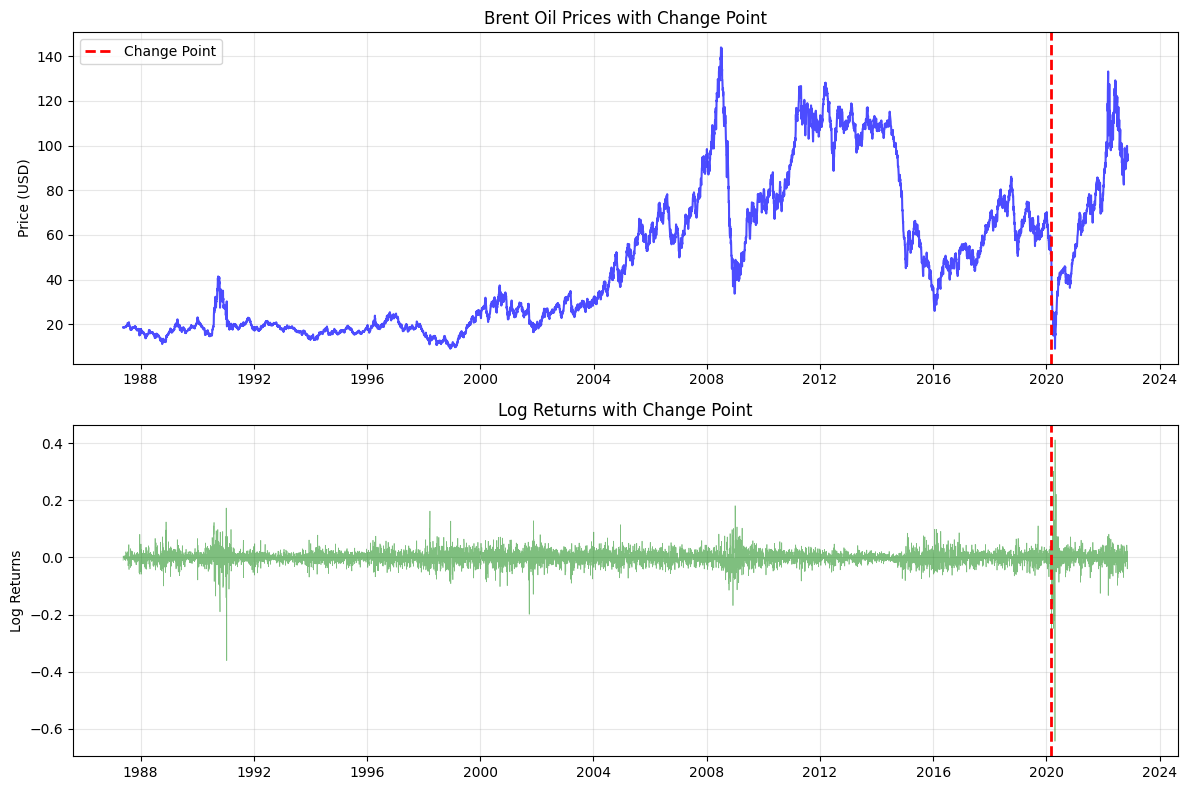

In [6]:
# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Price series
axes[0].plot(oil_data['Date'], oil_data['Price'], 'b-', alpha=0.7)
axes[0].axvline(change_date, color='red', linestyle='--', linewidth=2, label='Change Point')
axes[0].set_title('Brent Oil Prices with Change Point')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log returns
axes[1].plot(oil_data['Date'][1:], log_returns, 'g-', alpha=0.5, linewidth=0.5)
axes[1].axvline(change_date, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Log Returns with Change Point')
axes[1].set_ylabel('Log Returns')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Results summary
print("=" * 50)
print("CHANGE POINT ANALYSIS RESULTS")
print("=" * 50)
print(f"Change Point Date: {change_date.strftime('%Y-%m-%d')}")
print(f"Price before: ${before_mean:.2f}")
print(f"Price after: ${after_mean:.2f}")
print(f"Change: {change_percent:.1f}%")
print(f"\nClosest Event: {closest_event['event']}")
print(f"Event Date: {closest_event['date'].strftime('%Y-%m-%d')}")
print(f"Days difference: {days_diff}")
print("\n⚠️ LIMITATION: Correlation ≠ Causation")

CHANGE POINT ANALYSIS RESULTS
Change Point Date: 2020-03-06
Price before: $46.54
Price after: $71.38
Change: 53.4%

Closest Event: OPEC+ deal collapse
Event Date: 2020-03-06
Days difference: 0

⚠️ LIMITATION: Correlation ≠ Causation
